# Cálculo de armónicos esféricos utilizando computación cuántica.   
## TFE: Computación cuántica aplciada al análisis espacial en electroencefalografía - Procesador cuántico Real   
## Master universitario en computación cuántica (UNIR)   
### Francisco Vidal Requejo   
### Antonio José Ruz Hervás   

En este notebook se desarrolla el modelo teórico propuesto en el trabajo para la evaluación de armónicos esféricos mediante la utilización de computación cuántica. Se utiliza en este caso un procesador cuántico simulado para realizar el experimento. Se trata de utilizar armónicos esféricos en los datos de entrada de un modelo de inteligencia artificial (IA) que discrimine la intención motora. El resultado se muestra en una gráfica comparandolo con el resultado de la intención motora con aprendizaje automático clásico.

Se utiliza principalmente la librería mne para el preprocesado de los datos, la librería "pennylane" para el cálculo cuántico de los datos de entrada al modelo y la librería keras para el modelo convolucional utilizado.

In [1]:
%pip install pennylane > o
%pip install pennylane-qiskit > o

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Importación de librerías utilizadas en este archivo.

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import mne
from mne import events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

from sklearn.model_selection import train_test_split

from scipy.special import sph_harm

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

Ángulos utilizados para el cálculo de los armónicos esféricos. La primera coordenada corresponde con la coordenada azimutal y la segunda con la polar. Estos ángulos se corresponden con la posición de 64 electrodos de un EEG utilizando el "sistema 10-10" para elegir la posición de los mismos, considerando la cabeza como una esfera.

In [3]:
ANGLES = [['FC5.',-71,-21],
 ['FC3.',-50,-28],
 ['FC1.',-32,-45],
 ['FCz.',23,90],
 ['FC2.',32,45],
 ['FC4.',50,28],
 ['FC6.',71,21],
 ['C5..',-69,0],
 ['C3..',-46,0],
 ['C1..',23,0],
 ['Cz..',0,0],
 ['C2..',23,0],
 ['C4..',46,0],
 ['C6..',69,0],
 ['CP5.',-71,21],
 ['CP3.',-50,28],
 ['CP1.',-32,45],
 ['CPz.',23,-90],
 ['CP2.',32,-45],
 ['CP4.',50,-28],
 ['CP6.',71,-21],
 ['Fp1.',-92,-72],
 ['Fpz.',92,90],
 ['Fp2.',92,72],
 ['AF7.',-92,-52],
 ['AF3.',-74,-67],
 ['AFz.',69,90],
 ['AF4.',74,67],
 ['AF8.',92,52],
 ['F7..',-92,-36],
 ['F5..',-75,-41],
 ['F3..',-60,-51],
 ['F1..',-50,-68],
 ['Fz..',46,90],
 ['F2..',50,68],
 ['F4..',60,51],
 ['F6..',75,41],
 ['F8..',92,36],
 ['FT7.',-92,-18],
 ['FT8.',92,18],
 ['T7..',-92,0],
 ['T8..',92,0],
 ['T9..',-115,0],
 ['T10.',115,0],
 ['TP7.',-92,18],
 ['TP8.',92,-18],
 ['P7..',-92,36],
 ['P5..',-75,41],
 ['P3..',-60,51],
 ['P1..',-50,68],
 ['Pz..',46,-90],
 ['P2..',50,-68],
 ['P4..',60,-51],
 ['P6..',75,-41],
 ['P8..',92,-36],
 ['PO7.',-92,54],
 ['PO3.',-74,67],
 ['POz.',69,-90],
 ['PO4.',74,-67],
 ['PO8.',92,-54],
 ['O1..',-92,72],
 ['Oz..',92,-90],
 ['O2..',92,-72],
 ['Iz..',115,-90]
 ]

Inicialización de las constantes y variables generales utilizadas:

In [4]:
# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
ROW_EVENTS = ["hands", "feet"]

#runs
# 1 eyes open
# 2 eyes closed
# 3 open and close left or right fist
# 4 imagine opening and closing left or right fist
# 5 open and close both fits or both feet
# 6 imagine opening and closing both fists or both feet

EVENT_ID = dict(fits_left=2, fits_right=3) # Identificadores utilizados para la tarea escogida
RUNS = [3, 7, 11]  # Identificadores de la tarea de cerrar y abrir la mano. El 3, 7 y 11 son muestras de la misma tarea

# Valores para la tarea de imaginar que cerramos y abrimos manos o pies
#EVENT_ID = dict(fits=2, feet=3)
#RUNS = [6, 10, 14]  # motor imagine: hands vs feet

# Valor n-m para los armónicos esféricos utilizado
nmMAX = 2

# Número de usuario utilizado para los datos EEGs 
userNumber = 3

# Variables para el modelo convolucional de IA 
nEpochs = 50   # Numbero de epocas utilizadas en el entrenamiento del modelo de IA 
nLayers = 1    # Numbero de capas aleatorias utilizadas en el entrenamiento del modelo de IA 

#FREQ_FILTER = [[8, 12],[12, 16],[16, 20],[20, 24],[24,30],[7, 30]]
FREQ_FILTER = [[7, 30]]

# Directorio temporal donde se guardan los datos generados mediante convolución cuántica
SAVE_PATH = "quanvolution/" # Data saving folder

# Valores de configuración para la generación aleatoria
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Cálculo de los armónicos esféricos mediantes procesamiento clásico (cálculo de la matriz basado en https://www.programcreek.com/python/?code=AppliedAcousticsChalmers%2Fsound_field_analysis-py%2Fsound_field_analysis-py-master%2Fsound_field_analysis%2Fsph.py ):

In [5]:
def SphericalJoin (nMax, el, az):

    degs = np.arange(nMax + 1)
    n = np.repeat(degs, degs * 2 + 1)

    elementNumber = np.arange((nMax + 1) ** 2) + 1
    t = np.floor(np.sqrt(elementNumber - 1)).astype(int)
    m = elementNumber - t * t - t - 1

    mA, azA = np.meshgrid(m, az)
    nA, elA = np.meshgrid(n, el)
    return sph_harm(mA, nA, azA, elA)

channels = []
theta = []
phi = []
for fila in ANGLES:
    channels.append(fila[0].upper().replace(".", ""))
    theta.append(fila[1])
    phi.append(fila[2])

thetaArray = np.array(theta)
phiArray = np.array(phi)

(Theta,Phi)=np.meshgrid(thetaArray,phiArray) 

sphericalJoin=SphericalJoin(nmMAX, Theta, Phi)
conjugateSphericalJoin = sphericalJoin.conjugate()
sphericalAll = []
for indexPairs in range(len(thetaArray)):
    sphericalAll.append(conjugateSphericalJoin[indexPairs+ (indexPairs*len(thetaArray))])

print('Valores de los armónicos esféricos para el valor {} en el cálculo de los polinomios asociados de legendre.'.format(nmMAX))
print(sphericalAll[0])

Valores de los armónicos esféricos para el valor 2 en el cálculo de los polinomios asociados de legendre.
[ 0.28209479-0.j         -0.17997497-0.2749115j  -0.15098928-0.j
  0.17997497-0.2749115j  -0.13974964+0.32022065j  0.12436195+0.1899627j
 -0.22503657-0.j         -0.12436195+0.1899627j  -0.13974964-0.32022065j]


Funciones utilizadas en el modelo convolucional de IA (código basado en https://pennylane.ai/qml/demos/tutorial_quanvolution ):

In [6]:
devConvo = qml.device("default.qubit", wires=4)
randParams = np.random.uniform(high=2 * np.pi, size=(nLayers, 4))
@qml.qnode(devConvo, interface="autograd")
def circuit(phi):
    # Random circuit parameters
    
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(randParams, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((int(len(image)/2), int(len(image)/2), 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, len(image), 2):
        for k in range(0, len(image), 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

def processImage(trainImages, testImages):
    qTrainImages = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(trainImages):
        print("{}/{}        ".format(idx + 1, len(trainImages)), end="\r")
        qTrainImages.append(quanv(img))
    qTrainImages = np.asarray(qTrainImages)

    qTestImages = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(testImages):
        print("{}/{}        ".format(idx + 1, len(testImages)), end="\r")
        qTestImages.append(quanv(img))
    qTestImages = np.asarray(qTestImages)
    print()

    np.save(SAVE_PATH + "q_train_images.npy", qTrainImages)
    np.save(SAVE_PATH + "q_test_images.npy", qTestImages)

def MyModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation="softmax")
    ])
        
    model.compile(
        optimizer='adam', 
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model
    
def fitModel(trainImages, trainLabels, testImages, testLabels, nEpochs = 30, batchSize=4, verbose=2):
    model = MyModel()
    history = model.fit(
        trainImages,
        trainLabels,
        validation_data=(testImages, testLabels),
        batch_size=batchSize,
        epochs=nEpochs,
        verbose=verbose,
    )

    return history

Funciones auxiliares y para el preprocesado de los datos:

In [7]:
def displayEventPicks(raw, events, numEvent, picks, timeAction = 2):    
    startTime, endTime, timeEvent = getEventTime(events, numEvent, timeAction)
    fig, ax = plt.subplots(figsize=[15, 5])
    ax.plot(raw.get_data(picks=picks, tmin=startTime, tmax=endTime).T, color='b')
    plt.show()
    
def displayEvent(raw, events, numEvent, timeAction = 2):
    startTime, endTime, timeEvent = getEventTime(events, numEvent, timeAction)
    fig, ax = plt.subplots(figsize=[15, 5])
    ax.plot(raw.get_data(tmin=startTime, tmax=endTime).T, color='b')
    plt.show()

def displayConsecutiveEvent(raw, events, num_event, timeAction = 2, timeSpacing = 8.3):    
    startTime, endTime, startTimeNext, endTimeNext, timeEvent = getEventTimes(events, num_event, timeAction, timeSpacing)
    fig, ax = plt.subplots(figsize=[15, 5])
    for idx in range(len(ANGLES)):
        ax.plot(np.where(raw.get_data(tmin=startTime, tmax=endTime).T < 0.0002, 0, raw.get_data(tmin=startTime, tmax=endTime).T), color='g')
        ax.plot(raw.get_data(tmin=startTimeNext, tmax=endTimeNext).T, color='b')
    plt.show()

def getEventTime(events, numEvent, timeAction):
    timeEvent = events[numEvent, 0]/160
    startTime = timeEvent - timeAction/2
    endTime = timeEvent + timeAction/2 
    return round(startTime, 2), round(endTime, 2), round(timeEvent, 2)

def getEventTimes(events, num_event, timeAction, timeSpacing = 8.3):
    time_event = events[num_event, 0]/160
    start_time = time_event - timeAction/2
    end_time = time_event + timeAction/2 
    start_time_next = start_time + timeSpacing
    end_time_next = end_time + timeSpacing
    return round(start_time, 2), round(end_time, 2), round(start_time_next, 2), round(end_time_next, 2), round(time_event, 2)

def calculaMomentoEvento(rawDataInv, startTime):
    arrayIdxEvents = []

    valorMuestraAnterior = -1
    for idx in range(len(rawDataInv)):
        if(np.max(rawDataInv[idx]) > 0):
            print('np.max(rawDataInv[idx])', np.max(rawDataInv[idx]))
            if(valorMuestraAnterior != -1 and valorMuestraAnterior + 10 < idx):
                break
            arrayIdxEvents.append(idx)
            valorMuestraAnterior = idx

    mediaMuestras = int(np.mean(arrayIdxEvents))
    desviacionInicio = round(mediaMuestras/160, 3)
    momentoEvento = round(startTime + desviacionInicio, 3)

    return momentoEvento

def getDataSection(raw, events, indexEvent, picks, timeAction):
    
    startTime, endTime, timeEvent = getEventTime(events, indexEvent, timeAction)

    rawDataPicks = raw.get_data(picks=picks, tmin=startTime, tmax=endTime).T

    maxValue = -1
    maxValueIndex = -1
    for idxData in range(len(rawDataPicks)):
        for idxChannels in range(len(rawDataPicks[idxData])):
            if(np.max(rawDataPicks[idxData][idxChannels]) > maxValue):
                maxValue = np.max(rawDataPicks[idxData][idxChannels])
                maxValueIndex = idxData

    rawData = getValorMuestra(raw, maxValueIndex, startTime)
    return rawData
    
def getValorMuestra(raw, valorMuestra, startTime):
    startTime = startTime + round((valorMuestra-20)/160, 2)
    endTime = startTime + round(70/160, 2)
    rawDataTemp = raw.get_data(tmin=startTime, tmax=endTime).T

    rawData = []
    for idxRawData in range(len(raw.ch_names)):
        rawData.append(rawDataTemp[idxRawData])

    return np.asarray(rawData).T

def getFeaturesConvolucional(raw, events, sphericalAll):
    picks=['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2']
    timeAction = 1.2
    featureX = []
    featureY = []

    featureXTemp = []
    for indexEvent in range(len(events)):
        featureY.append(events[indexEvent][2])
        rawDataSection = getDataSection(raw, events, indexEvent, picks, timeAction)
        featureXTemp.append(rawDataSection)

    for indexEvent in range(len(featureXTemp)): # 1 o 2
        featureX.append([])
        for indexChannels in range(len(featureXTemp[indexEvent])): # 64
            featureValueX = featureXTemp[indexEvent][indexChannels] # cada sensor tiene su array
            for indexFeature in range(len(featureValueX)): # 16161                
                if(len(featureX[indexEvent]) == indexFeature):
                    featureX[indexEvent].append([0])
                if(len(featureX[indexEvent][indexFeature]) == indexChannels):
                    featureX[indexEvent][indexFeature].append(0)
                for indexSpherical in range(len(sphericalAll[indexChannels])): # g 4 o 9 o ...
                    featureX[indexEvent][indexFeature][indexChannels] = featureX[indexEvent][indexFeature][indexChannels] + (np.real(featureValueX[indexFeature])*np.real(sphericalAll[indexChannels][indexSpherical]))                       

    return np.asarray(featureX), np.asarray(featureY)

def printHistory(q_history, c_history):
    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

    ax1.plot(q_history.history["val_accuracy"], "-ob", label="Con capa cuántica")
    ax1.plot(c_history.history["val_accuracy"], "-og", label="Sin capa cuántica")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(q_history.history["val_loss"], "-ob", label="Con capa cuántica")
    ax2.plot(c_history.history["val_loss"], "-og", label="Sin capa cuántica")
    ax2.set_ylabel("Loss")
    ax2.set_ylim(top=2.5)
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.tight_layout()
    plt.show()

Funciones de lectura de los datos de EEGs (Datos obtenidos de https://www.kaggle.com/datasets/brianleung2020/eeg-motor-movementimagery-dataset , Apache 2.0 open source license):

Extracting EDF parameters from C:\Users\ajruz\Desktop\UNIR\Proyecto_TFM\datos\brianleung2020\files\MNE-eegbci-data\files\eegmmidb\1.0.0\S003\S003R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\ajruz\Desktop\UNIR\Proyecto_TFM\datos\brianleung2020\files\MNE-eegbci-data\files\eegmmidb\1.0.0\S003\S003R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\ajruz\Desktop\UNIR\Proyecto_TFM\datos\brianleung2020\files\MNE-eegbci-data\files\eegmmidb\1.0.0\S003\S003R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...

Tiempo de los eventos:
[  4.2  12.5  20.8  29.1  37.4  45.7  54.   62.3  70.6  78.9  87.2  95.5
 103.8 112.1 120.4

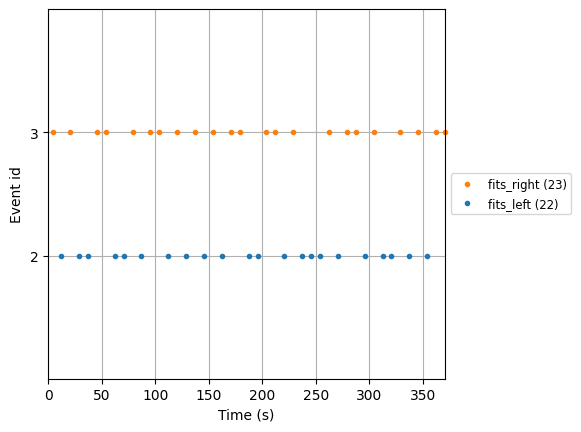

In [8]:
rawFilters = []
historyFilters = []

files = eegbci.load_data(userNumber, RUNS, './files/', verbose="error")
raws = [read_raw_edf(f, preload=True) for f in files]
raw = concatenate_raws(raws)
eegbci.standardize(raw)  # set channel names
raw.set_montage(make_standard_montage("standard_1005"))

print()
print('Tiempo de los eventos:')
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3), verbose="error")
print(events[:, 0]/160)
print()
print('Evento producido:')
print(events[:, 2])

fig = mne.viz.plot_events(events, sfreq=raw.info["sfreq"], first_samp=raw.copy().first_samp, event_id=EVENT_ID)

Función principal de la ejecución:

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Quantum pre-processing of train images:
36/36        
Quantum pre-processing of test images:
9/9        
Epoch 1/30
9/9 - 0s - loss: 3.0868 - accuracy: 0.3611 - val_loss: 1.2558 - val_accuracy: 0.6667 - 464ms/epoch - 52ms/step
Epoch 2/30
9/9 - 0s - loss: 2.2893 - accuracy: 0.5000 - val_loss: 0.6973 - val_accuracy: 0.6667 - 57ms/epoch - 6ms/step
Epoch 3/30
9/9 - 0s - loss: 2.6033 - accuracy: 0.4444 - val_loss: 0.7482 - val_accuracy: 0.3333 - 56ms/epoch - 6ms/step
Epoch 4/30
9/9 - 0s - loss: 2.2998 - accuracy: 0.5556 - val_loss: 0.8771 - val_accuracy: 0.6667 - 59ms/epoch - 7ms/step
Epoch 5/30
9/9 - 0s - loss: 1.3932 - accuracy: 0.4722 - val_loss: 0.8401 - val_accuracy: 0.3333 - 60ms/epoch - 7ms/step
Epoch 6/30
9/9 - 0s - loss: 1.0289 - accuracy: 0.7222 - val_loss: 0.8218 - val_accuracy: 0.6667 - 62ms/epoch - 7ms/step
Epoch 7/30
9/9 - 0s - loss: 1.2187 - accuracy: 0.5833 - val_loss: 0.6464 - val_accuracy: 0.6667 - 57ms/epoch - 6ms/step
Epoch 8/30
9/9 - 0s - loss: 1.6769 - accuracy: 0.3611

C:\Users\ajruz\AppData\Local\Temp\ipykernel_42604\1032089901.py:108: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


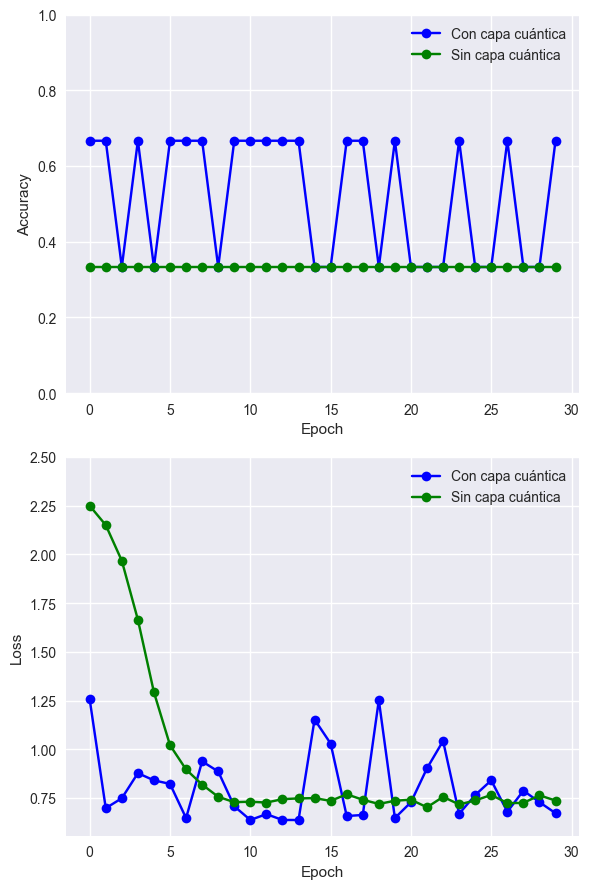

In [9]:

for index in range(len(FREQ_FILTER)):
    
    rawFilter = raw.copy().filter(FREQ_FILTER[index][0], FREQ_FILTER[index][1], fir_design='firwin', skip_by_annotation='edge')
    rawFilters.append(rawFilter)
    
    featureStepFilter = getFeaturesConvolucional(rawFilter, events, sphericalAll)
     
    trainImages, testImages, trainLabels, testLabels = train_test_split(featureStepFilter[0], featureStepFilter[1], train_size=0.8)
    trainImages = np.array(trainImages[..., tf.newaxis], requires_grad=False)
    testImages = np.array(testImages[..., tf.newaxis], requires_grad=False)
    
    processImage(trainImages, testImages)

    qTrainImages = np.load(SAVE_PATH + "q_train_images.npy")
    qTestImages = np.load(SAVE_PATH + "q_test_images.npy")
    
    qHistory = fitModel(qTrainImages, trainLabels, qTestImages, testLabels, nEpochs = 30)
    cHistory = fitModel(tf.convert_to_tensor(np.real(trainImages), dtype=tf.float64) , trainLabels, tf.convert_to_tensor(np.real(testImages), dtype=tf.float64), testLabels, nEpochs = 30)
    
    historyFilters.append([qHistory, cHistory])         

for qHistory, cHistory in historyFilters :
    printHistory(qHistory, cHistory)      


Muestra de dos eventos producidos. Gráfica de un muestreo de 1 segundo sobre datos filtrados utilizando todos los canales (todos los sensores que tiene el EEG):

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


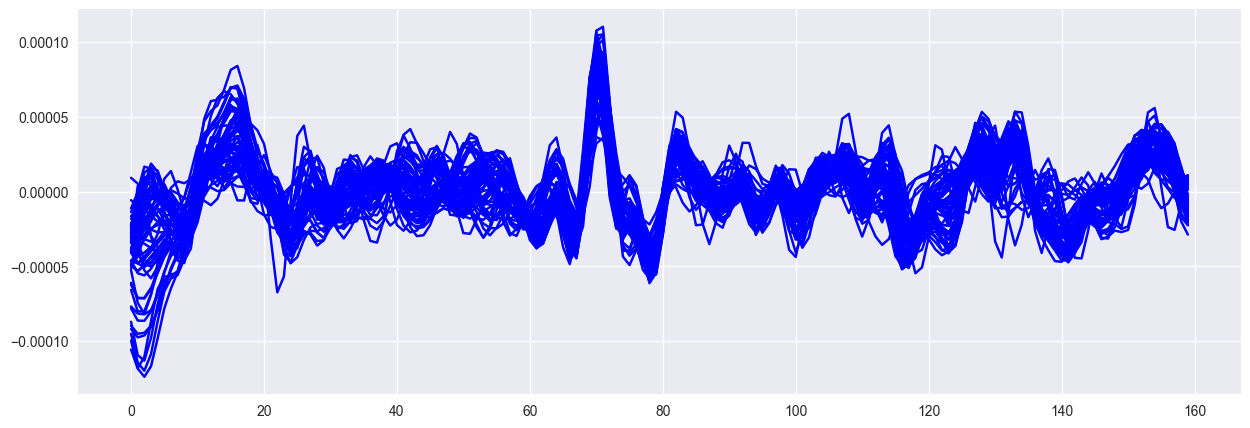

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


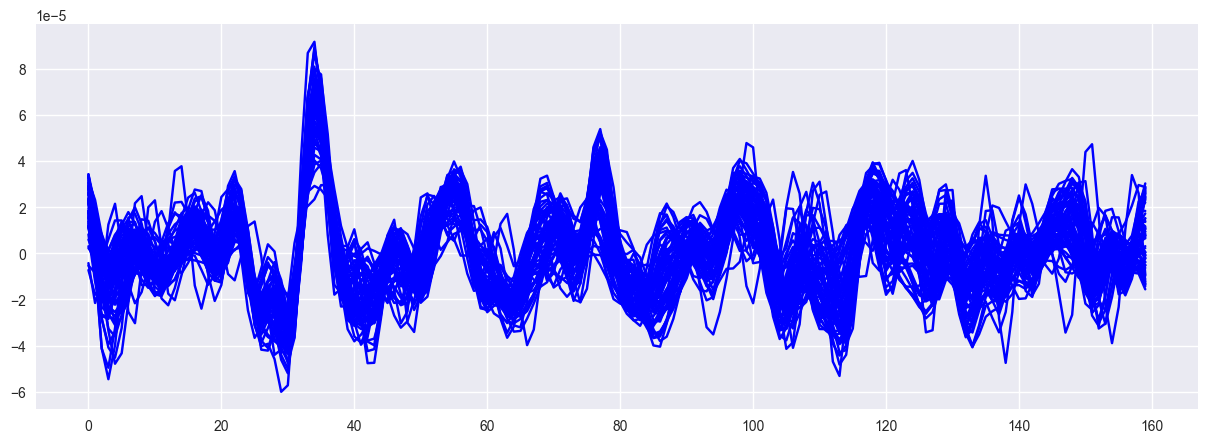

In [10]:
idxFreq = 0
numEvent=0
displayEvent(raw.copy().filter(FREQ_FILTER[idxFreq][0], FREQ_FILTER[idxFreq][1], fir_design='firwin', skip_by_annotation='edge'), events, numEvent, timeAction = 1)
numEvent=2
displayEvent(raw.copy().filter(FREQ_FILTER[idxFreq][0], FREQ_FILTER[idxFreq][1], fir_design='firwin', skip_by_annotation='edge'), events, numEvent, timeAction = 1)

Figura que muestra los canales disponibles en los datos EEGs (sensores que tiene los datos de EEG utilizados):

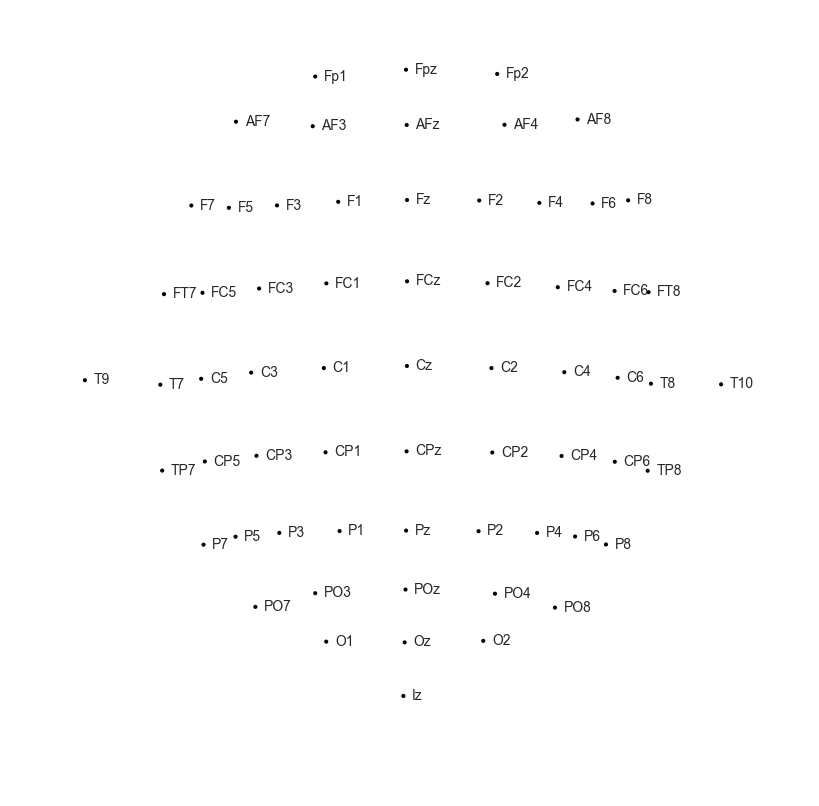

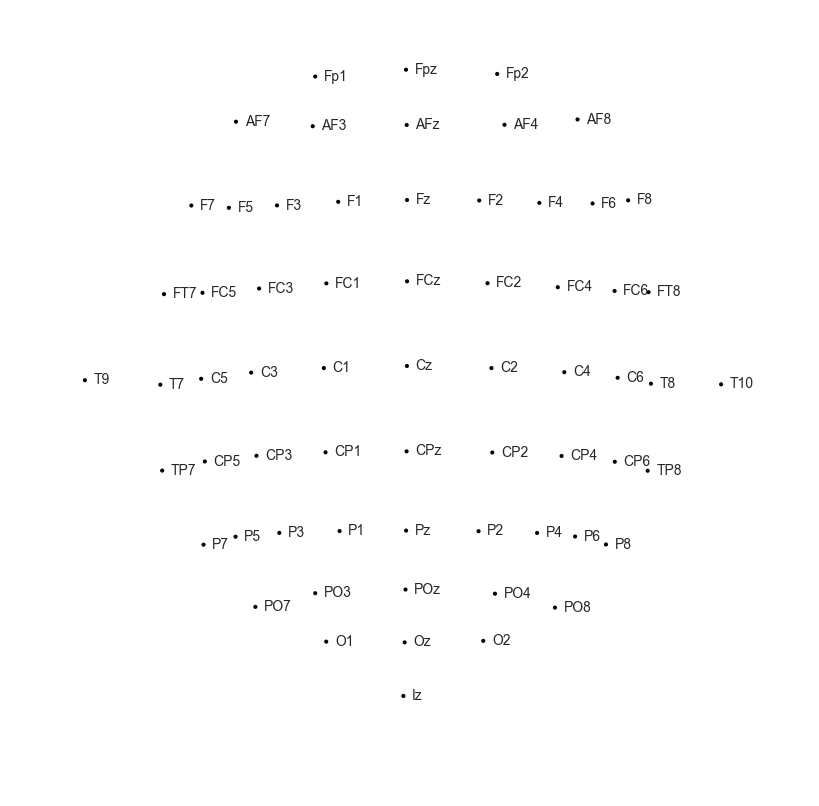

In [11]:
raw.plot_sensors(show_names=True)